# VQE exercise
Erel Dekel - 326064888 \
Dolev Shmaryahu - 326526258 \
Due to 03.07.2024

**Installations**

In [23]:
#%pip uninstall qiskit qiskit-aer qiskit-algorithms qiskit-ibm-runtime qiskit-ibm-provider
%pip install qiskit
%pip install numpy
%pip install qiskit-aer
%pip install qiskit-algorithms
%pip install matplotlib
%pip install qiskit-ibm-runtime
%pip install qiskit-ibm-provider



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Imports and code constants**


In [24]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
import matplotlib.image as mpimg

from qiskit import transpile
from qiskit_algorithms import VQE
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import Estimator
from qiskit.exceptions import QiskitError
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import circuit_drawer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info.operators import Operator
from qiskit_aer import Aer, QasmSimulator, AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

my_token = "d407187f614ca93bb6915bcd05eca072ee41ecdd390576d59743ec40c7d65bea240ab5098753d2608c5b80327f5c2fd1b2197a3a064eeac626781f2d5374cb98"

**Constract H2 Hamiltonian**

In [25]:
g_0 = -0.4804
paulis = ["ZI", "IZ", "ZZ", "YY", "XX"]
coeffs = [0.3435, -0.4347, 0.5716, 0.0910, 0.0910]

H2 = g_0*Operator(qi.SparsePauliOp("II")) \
    +coeffs[0]*Operator(qi.SparsePauliOp(paulis[0])) \
    + coeffs[1]*Operator(qi.SparsePauliOp(paulis[1])) \
    + coeffs[2]*Operator(qi.SparsePauliOp(paulis[2])) \
    + coeffs[3]*Operator(qi.SparsePauliOp(paulis[3])) \
    + coeffs[4]*Operator(qi.SparsePauliOp(paulis[4]))
H2

Operator([[ 1.11022302e-16+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j, -2.73800000e-01+0.j,  1.82000000e-01+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  1.82000000e-01+0.j, -1.83020000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
            1.82400000e-01+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


**Part 1: find the exact solution**

In [26]:
# Find min eigenvalue
eigen_values = np.linalg.eigvalsh(H2)
min_eigenvalue = min(eigen_values)

print("Exact result: " + str(min_eigenvalue))

nuclear_repulsion = 0.7055696146
hydrogen_atom_min_eigenvalue = min_eigenvalue + nuclear_repulsion

Exact result: -1.851199124123644


**Part 2: VQE using ideal simulation**

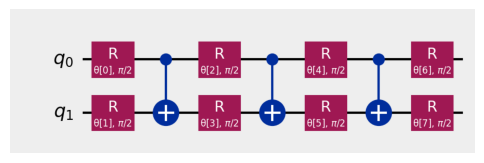

VQE on Aer qasm simulator (noisy): -1.0476766
VQE on Aer qasm simulator (noisy): -1.3468330
VQE on Aer qasm simulator (noisy): -1.8303337
VQE on Aer qasm simulator (noisy): -1.5249264
VQE on Aer qasm simulator (noisy): -1.3314152
VQE on Aer qasm simulator (noisy): -1.3860051
VQE on Aer qasm simulator (noisy): -1.5390865
VQE on Aer qasm simulator (noisy): -1.3121652
VQE on Aer qasm simulator (noisy): -1.4093940
VQE on Aer qasm simulator (noisy): -1.7829967
VQE on Aer qasm simulator (noisy): -1.7489046
VQE on Aer qasm simulator (noisy): -1.8382741
VQE on Aer qasm simulator (noisy): -1.8274105
VQE on Aer qasm simulator (noisy): -1.7032803
VQE on Aer qasm simulator (noisy): -1.8135319
VQE on Aer qasm simulator (noisy): -1.8124483
VQE on Aer qasm simulator (noisy): -1.8215938
VQE on Aer qasm simulator (noisy): -1.8200257
VQE on Aer qasm simulator (noisy): -1.8155879
VQE on Aer qasm simulator (noisy): -1.8243124
VQE on Aer qasm simulator (noisy): -1.8191001
VQE on Aer qasm simulator (noisy):

In [27]:
def ansatz_2local(reps = 1, show = False, num_qubits = 2):
    ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks='ry', entanglement_blocks='cx', reps=reps)

    if show:
        full_circuit = ansatz.decompose().decompose()
        circuit_drawer(full_circuit, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='ansatz_circuit.png')
        img = mpimg.imread('ansatz_circuit.png')
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    return ansatz

def create_vqe_store_callback():
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f"VQE on Aer qasm simulator (noisy): {mean:.7f}")
    
    return store_intermediate_result, counts, values

def run_VQE(ansatz, optimizer, estimator, operator, action=None):
    args = []
    if action:
        callback, *args = action()
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer, callback=callback)
    else:
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer)

    result = vqe.compute_minimum_eigenvalue(operator=SparsePauliOp.from_operator(operator))
    return result.eigenvalue.real, *args
    

ansatz = ansatz_2local(reps = 3, show = True)
optimizer = COBYLA(maxiter=200)
estimator = Estimator(options={"shots": 10**4})

vqe_ideal_ground_state_energy, *args = run_VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator, operator=H2, action=create_vqe_store_callback)

print(f"VQE Ground State Energy: {vqe_ideal_ground_state_energy}")
print(f"Error: {vqe_ideal_ground_state_energy - min_eigenvalue}")

**Part 3: VQE using noisy simulation**

In [28]:
ansatz = ansatz_2local(reps = 3)
coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]

fake_lima = FakeLimaV2()
noise_model = NoiseModel.from_backend(fake_lima)
print(noise_model)

seed = 170
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 10**4},
    transpile_options={"seed_transpiler": seed},
)

optimizer = COBYLA(maxiter=200)

vqe_noisy_ground_state_energy, *args = run_VQE(ansatz=ansatz, optimizer=optimizer, estimator=noisy_estimator, operator=H2, action=create_vqe_store_callback)
print(f"VQE Ground State Energy: {vqe_noisy_ground_state_energy}")
print(f"Error: {vqe_noisy_ground_state_energy - min_eigenvalue}")

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'sx', 'id', 'measure', 'cx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (3, 1)), ('cx', (3, 4)), ('cx', (4, 3)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
VQE on Aer qasm simulator (noisy): 0.0724699
VQE on Aer qasm simulator (noisy): -0.0794459
VQE on Aer qasm simulator (noisy): -0.6190007
VQE on Aer qasm simulator (noisy): -0.6647080
VQE on Aer qasm simulator (noisy): -0.7096442
VQE on Aer qasm simulator (noisy): -0.

Part 4: VQE using real hardware

In [31]:
try:
    provider = IBMProvider(token=my_token)
    print("Successfully loaded IBM Quantum account.")
except:
    IBMProvider.save_account(token=my_token, instance="ibm-q/open/main", overwrite=True)
    provider = IBMProvider(token=my_token)
    print("Saved and loaded IBM Quantum account.")

service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

# Print available backends (optional)
# for backend in service.backends():
#   print(f"Name: {backend.name}, Qubits: {backend.configuration().n_qubits}, Simulator: {backend.configuration().simulator}")

backend = service.least_busy(min_num_qubits=2, filters=lambda x: x.configuration().n_qubits >= 2)
if backend is None:
    print("No suitable backend found. Please adjust filter criteria or try again later.")
    exit()

print(f"Using BackEnd {backend.name}")

Successfully loaded IBM Quantum account.
Using BackEnd ibm_kyoto


KeyboardInterrupt: 

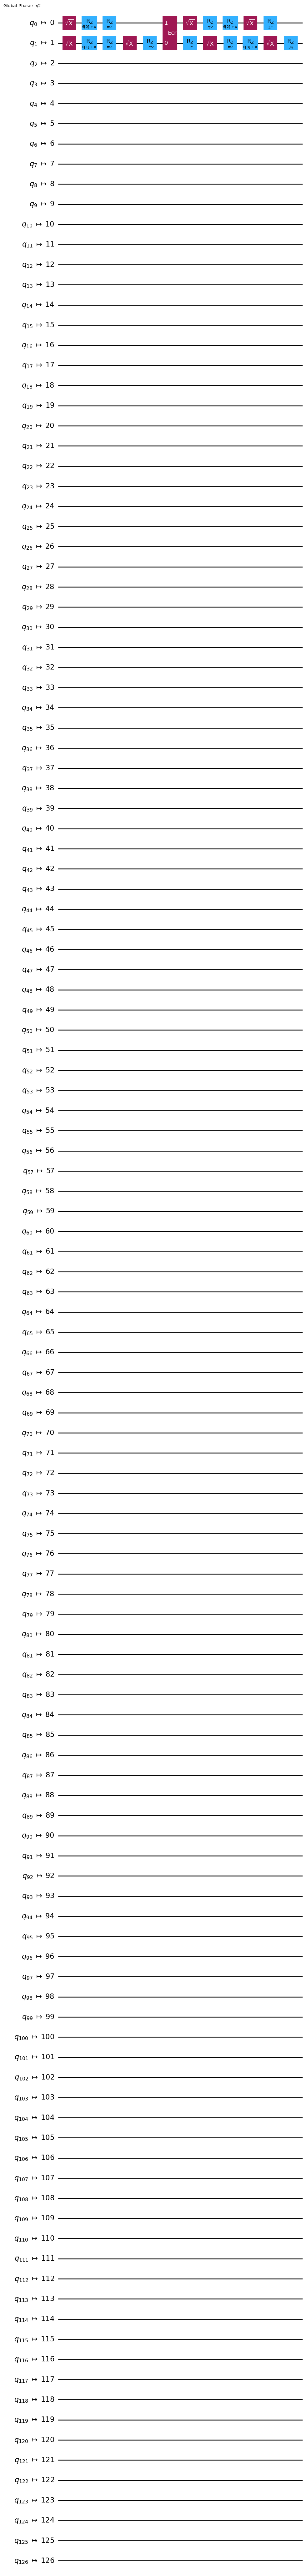

In [38]:
# from qiskit import QuantumCircuit

ansatz = ansatz_2local()

# def embed_ansatz(ansatz, target_qubits, total_qubits):
#     embedded_circuit = QuantumCircuit(total_qubits)
#     embedded_circuit.compose(ansatz, qubits=target_qubits, inplace=True)
#     return embedded_circuit

# target_qubits = [0, 1] 
# embedded_ansatz = embed_ansatz(ansatz, target_qubits, total_qubits=backend.num_qubits)
transpiled_circuit = transpile(ansatz, backend=backend)
transpiled_circuit.draw('mpl')

In [39]:
optimizer = COBYLA(maxiter=200)

def run_vqe_hardware(use_mitigation=False):
    with Session(service=service, backend=backend) as session:
        # Set up options
        options = Options()
        options.optimization_level = 1
        options.resilience_level = 1 if use_mitigation else 0
        options.execution.shots = 10**4

        # Create the estimator
        estimator = RuntimeEstimator(session=session, options=options)

        # Run VQE
        vqe = VQE(estimator=estimator, ansatz=transpiled_circuit, optimizer=optimizer)
        operator = SparsePauliOp.from_operator(H2)
        result = vqe.compute_minimum_eigenvalue(operator=operator)
        
        return result.eigenvalue.real

# Run VQE without error mitigation
print("Running VQE without error mitigation...")
energy_no_mitigation = run_vqe_hardware(use_mitigation=False)
print(f"Ground state energy without mitigation: {energy_no_mitigation}")

# Run VQE with error mitigation
print("Running VQE with error mitigation...")
energy_with_mitigation = run_vqe_hardware(use_mitigation=True)
print(f"Ground state energy with mitigation: {energy_with_mitigation}")

# Calculate errors
error_no_mitigation = abs(energy_no_mitigation - min_eigenvalue)
error_with_mitigation = abs(energy_with_mitigation - min_eigenvalue)

print(f"Error without mitigation: {error_no_mitigation}")
print(f"Error with mitigation: {error_with_mitigation}")


Running VQE without error mitigation...


C:\Users\ereld\AppData\Local\Temp\ipykernel_14208\2985748270.py:12: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = RuntimeEstimator(session=session, options=options)


AlgorithmError: 'The number of qubits of the ansatz does not match the operator, and the ansatz does not allow setting the number of qubits using `num_qubits`.'